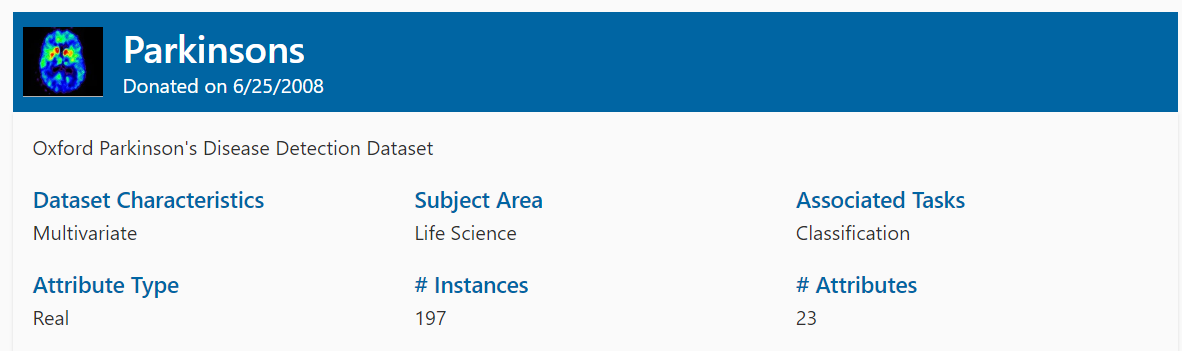


##  Data    
<a href="https://archive.ics.uci.edu/dataset/174/parkinsons">UCI Machine Learning</a>
    

## Objectives

After completing this lab you will be able to:

* Use <a href="https://snapml.readthedocs.io/en/latest/decision_trees.html">IBM snapML</a> Decision Tree to classify yer or no


## **Additional Information**

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. 




<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


## import packages


In [2]:
#pip install --upgrade pip

In [3]:
#!pip install snapml

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
%matplotlib inline 
import matplotlib.pyplot as plt

# dealing with imbalance classes
from imblearn.over_sampling import SMOTE
from collections import Counter

# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data From CSV File  


In [5]:
parkinson_ox = pd.read_csv("parkinsons.csv")
parkinson_ox.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [6]:
# shape
parkinson_ox.shape

(195, 24)

## Basic EDA

In [7]:
# check the columns
parkinson_ox.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [8]:
# data types
parkinson_ox.dtypes

name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

In [9]:
# missing values
parkinson_ox.isnull().any().sum()

0

In [10]:
# value count of the class to see if we are dealing with a balanced or unbalanced dataset
parkinson_ox['status'].value_counts(normalize=True)

1    0.753846
0    0.246154
Name: status, dtype: float64

**Outcome column** : class is unbalance with the presence of parkinson disease up making 75.39% of the data set and absent 24.62%.

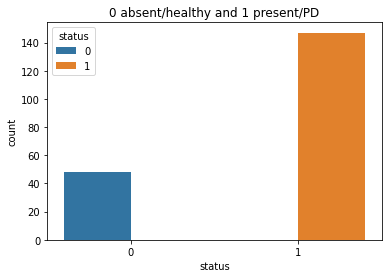

In [11]:
# now let's visualize the outcome
sns.countplot(data=parkinson_ox , x='status', hue='status').set(title = "0 absent/healthy and 1 present/PD");

## Data pre-processing and selection


In [12]:
# let's drop useless column like the id
parkinson_ox.drop(['name'], axis = 1, inplace = True) 

### Assign y(target) and X(input/features):

In [13]:
# target value
y =  parkinson_ox['status']

In [14]:
# let's drop the 'class' column
parkinson_ox.drop(['status'], axis = 1, inplace = True) 

## Train/Test dataset


We split our dataset into train and test set:


In [15]:
X = parkinson_ox.copy()
y = y.copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (156, 22) (156,)
Test set: (39, 22) (39,)


## Feature scaling


In [17]:
scaler = StandardScaler() # scaler objecy
X_train = scaler.fit_transform(X_train.to_numpy()) # allow the scaler object to learn the features and transform the training data
X_test =  scaler.transform(X_test.to_numpy()) # apply the learned features on the test set

In [18]:
# scaled x_train
X_train = np.asarray(X_train)
X_train.shape 

(156, 22)

In [19]:
# scaled x_test
X_test = np.asarray(X_test)
X_test.shape 

(39, 22)

<div id="svm_snap">
    <h2>Build a RandomForest model with Snap ML</h2>
</div>


In [29]:
%%time
# import the RandomForest from Snap ML
from snapml import RandomForestClassifier as SnapForest

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of RandomForest
# to use the GPU, set the use_gpu parameter to True
# rf = SnapForest(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
rf = SnapForest(n_estimators=10, criterion='gini', 
                            max_depth=4, min_samples_leaf=1, 
                            max_features='auto', bootstrap=True, 
                            n_jobs=1, random_state=None, verbose=False, 
                            use_histograms=False, hist_nbins=256, 
                            use_gpu=False, gpu_ids=[0], 
                            compress_trees=False)

# train an SVM model using Snap ML
clf = rf.fit(X_train, np.asarray(y_train))

CPU times: total: 0 ns
Wall time: 3 ms


After being fitted, the model can then be used to predict new values:


In [30]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 0, 1, 1], dtype=int64)

<h2 id="evaluation">Evaluation</h2>


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.85      1.00      0.92        29

    accuracy                           0.87        39
   macro avg       0.93      0.75      0.79        39
weighted avg       0.89      0.87      0.86        39

Confusion matrix, without normalization
[[ 5  5]
 [ 0 29]]


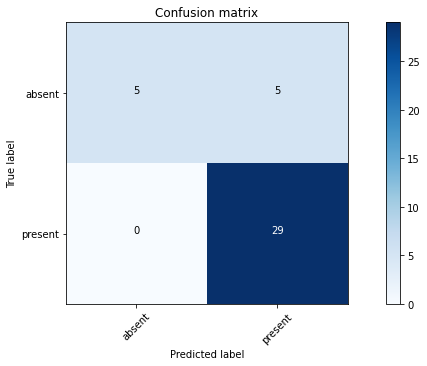

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
#np.set_printoptions(precision=2)

print (classification_report(y_test, yhat,labels=np.unique(yhat)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(11,5))
plot_confusion_matrix(cnf_matrix, ['absent','present'],normalize= False,  title='Confusion matrix')

You can also easily use the __sklearn metrics__ to evaluate our model:

In [73]:
from sklearn.metrics import f1_score, precision_score, jaccard_score, accuracy_score, recall_score 

In [74]:
print("Accuracy: %.4f" % accuracy_score(y_test, yhat))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat))
print("Precision: %.4f" % precision_score(y_test, yhat))
print("Recall: %.4f" % recall_score(y_test, yhat))
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))

Accuracy: 0.8718
Jaccard score: 0.8529
Precision: 0.8529
Recall: 1.0000
Avg F1-score: 0.8555


### Pickle the model:

We'll pickle the model so we don't have to refit it every time we run this notebook. Remember, there are three steps:

   1. Define the path to the location where it will save
   2. Write the file (i.e., save the model)
   3. Read the model back in

In [75]:
# This module lets us save our models once we fit them.
import pickle

# Pickle the model
with open('Parkinson_ox(RF-snapML).pickle', 'wb') as to_write:
    pickle.dump(rf, to_write) 

In [76]:
# Open pickled model
with open('Parkinson_ox(RF-snapML).pickle', 'rb') as to_read:
    rf_snapML = pickle.load(to_read)

<h2 id="practice">Practice</h2>
Now use a <a href="https://snapml.readthedocs.io/en/latest/boosting_machines.html">Boosting Machine Classifier</a> to see how the decision change.

### Boosting Machine Classifier

In [77]:
%%time
# import the BoostingMachineClassifier from Snap ML
from snapml import BoostingMachineClassifier as BoostMachine

Booting_clf = BoostMachine(n_jobs=1, num_round=100, max_depth=4, 
                                 min_max_depth=1, max_max_depth=5, early_stopping_rounds=10, 
                                 random_state=0, base_score=None, learning_rate=0.1, verbose=False, 
                                 compress_trees=False, class_weight=None, use_histograms=True, 
                                 hist_nbins=256, use_gpu=False, gpu_ids=[0], colsample_bytree=1.0,
                                 subsample=1.0, lambda_l2=0.0, 
                                 tree_select_probability=1.0, regularizer=1.0,
                                 fit_intercept=False, gamma=1.0, n_components=10)


Booting_clf.fit(X_train, y_train) 
yhat2 = Booting_clf.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 79.5 ms


You can also easily use the __sklearn metrics__ to evaluate our model:

In [78]:
# print the F1-score and jaccard_score
print("Accuracy: %.4f" % accuracy_score(y_test, yhat2))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2))
print("Precision: %.4f" % precision_score(y_test, yhat2))
print("Recall: %.4f" % recall_score(y_test, yhat2))
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))

Accuracy: 0.8974
Jaccard score: 0.8788
Precision: 0.8788
Recall: 1.0000
Avg F1-score: 0.8879


              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.88      1.00      0.94        29

    accuracy                           0.90        39
   macro avg       0.94      0.80      0.84        39
weighted avg       0.91      0.90      0.89        39

Confusion matrix, without normalization
[[ 6  4]
 [ 0 29]]


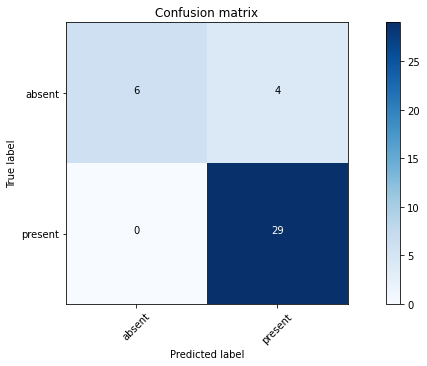

In [79]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2)
#np.set_printoptions(precision=2)

print (classification_report(y_test, yhat2,labels=np.unique(yhat2)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(11,5))
plot_confusion_matrix(cnf_matrix, classes=['absent','present'],normalize= False,  title='Confusion matrix')

### Save the boosting machine model:

In [80]:
# This module lets us save our models once we fit them.
import pickle

# Pickle the model
with open('Parkinson_ox(Boost-snapML).pickle', 'wb') as to_write:
    pickle.dump(Booting_clf, to_write) 

In [81]:
# Open pickled model
with open('Parkinson_ox(Boost-snapML).pickle', 'rb') as to_read:
    boosting_snapML = pickle.load(to_read)

### Thank you for completing this lab!

